# Аналитика в Яндекс.Афише

### Описание проекта


Нас пригласили на стажировку в отдел аналитики Яндекс.Афиши. ***Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.***
У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
+ лог сервера с данными о посещениях сайта Яндекс.Афиши,
+ выгрузка всех заказов за этот период,
+ статистика рекламных расходов.

**Нам нужно изучить:**
+ как люди пользуются продуктом,
+ когда они начинают покупать,
+ сколько денег приносит каждый клиент
+ когда клиент окупается.

**Описание данных**

*Таблица visits* (лог сервера с информацией о посещениях сайта):
+ Uid — уникальный идентификатор пользователя
+ Device — категория устройства пользователя
+ Start Ts — дата и время начала сессии
+ End Ts — дата и время окончания сессии
+ Source Id — идентификатор рекламного источника, из которого пришел пользователь

*Таблица orders* (информация о заказах):
+ Uid — уникальный id пользователя, который сделал заказ
+ Buy Ts — дата и время заказа
+ Revenue — выручка Яндекс.Афиши с этого заказа

*Таблица costs* (информация о затратах на маркетинг):
+ source_id — идентификатор рекламного источника
+ dt — дата
+ costs — затраты на этот рекламный источник в этот день

## Шаг 1. Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [4]:
orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450
5  2017-06-01 08:43:00     0.18  10402394430196413321
6  2017-06-01 08:54:00     1.83  12464626743129688638
7  2017-06-01 09:22:00     1.22   3644482766749211722
8  2017-06-01 09:22:00     3.30  17542070709969841479
9  2017-06-01 09:23:00     0.37   1074355127080856382

In [5]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

В датасете **visits** и **orders** нужно привести название столбцов к нижнему регистру, убрать пробелы. Поменять тип данных в столбцах с датой.

## Шаг 2. Построим отчёты и посчитаем метрики

### Продукт

***Сколько людей пользуются в день, неделю, месяц?***

In [6]:
visits.columns = ['device','end_ts','source_id','start_ts','uid'] # приведём название столбцов к правильному виду
visits.head()

device               end_ts  source_id             start_ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [7]:
#Изменим тип данных на datetime64
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [8]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [9]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  session_year  session_month  session_week  \
0  16879256277535980062          2017             12            51   
1    104060357244891740          2018              2             8   
2   7459035603376831527          2017              7            26   
3  16174680259334210214          2018              5            20   
4   9969694820036681168          2017             12            52   

  session_date  
0   2017-12-20  
1   2018-02-19  
2   2017-07-01  
3   2018-05-20  
4   2017-12-27

In [10]:
dau_total = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
wau_total = visits.groupby(['session_year','session_week']).agg({'uid':'nunique'}).mean()
mau_total = visits.groupby(['session_year','session_month']).agg({'uid':'nunique'}).mean()

In [11]:
int(dau_total)#В среднем пользователей в день

907

In [12]:
int(wau_total)#В среднем пользователей в неделю

5716

In [13]:
int(mau_total)#В среднем пользователей в месяц

23228

**Сколько сессий в день?**

In [14]:
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user['n_sessions'].mean().round() # Среднее количество сессий в день.

987.0

**Сколько длится одна сессия?**

In [15]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].mean().round()# Среднее время сессии

644.0

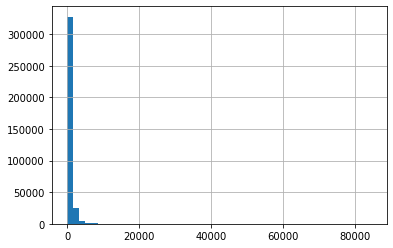

In [16]:
visits['session_duration_sec'].hist(bins=50)# Посмотрим на распределение

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду

In [17]:
asl = visits['session_duration_sec'].mode()
asl # Среднее время сессии

0    60
dtype: int64

Большинство людей заходят сразу купить, а не посидеть на ресурсе!

**Как часто люди возвращаются?**

In [18]:
#Воспользуемся метрикой "sticky factor", чтобы увидеть какой процент пользователей возвращается.
sticky_mau = dau_total/mau_total * 100
sticky_wau = dau_total/wau_total * 100

In [19]:
# Пользователей возвращается в месяц
sticky_mau.round(2).astype(str) + '%'

uid    3.91%
dtype: object

In [20]:
# Пользователей возвращается в неделю
sticky_wau.round(2).astype(str) + '%'

uid    15.88%
dtype: object

Для более детального отображения, посчитаем Retention Rate.

In [21]:
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')

In [22]:
visits

device              end_ts  source_id            start_ts  \
0         touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4       desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
...         ...                 ...        ...                 ...   
359395  desktop 2017-07-29 19:07:19          2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:38:19          1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:12:19          4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:12:19          5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:13:19          2 2017-09-10 13:13:00   

                         uid  session_year  session_month  session_week  \
0       16879256277535980062          2017             12            51   
1         104060357244891740          2018              2             8   
2        7459035603376831527          2017              7            26   
3       16174680259334210214          2018              5            20   
4        9969694820036681168          2017             12            52   
...                      ...           ...            ...           ...   
359395  18363291481961487539          2017              7            30   
359396  18370831553019119586          2018              1             4   
359397  18387297585500748294          2018              3             9   
359398  18388616944624776485          2017             11            44   
359399  18396128934054549559          2017              9            36   

       session_date  session_duration_sec first_activity_date  
0        2017-12-20                  1080 2017-12-20 17:20:00  
1        2018-02-19                  1680 2018-02-19 16:53:00  
2        2017-07-01                     0 2017-07-01 01:54:00  
3        2018-05-20                  1440 2018-03-09 20:05:00  
4        2017-12-27                     0 2017-12-27 14:06:00  
...             ...                   ...                 ...  
359395   2017-07-29                    19 2017-07-29 19:07:00  
359396   2018-01-25                    19 2018-01-25 17:38:00  
359397   2018-03-03                    19 2018-03-03 10:12:00  
359398   2017-11-02                    19 2017-11-02 10:12:00  
359399   2017-09-10                    19 2017-09-10 13:13:00  

[359400 rows x 11 columns]

In [23]:
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)

In [24]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [25]:
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(inital_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')

In [26]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

In [27]:
retention_pivot.fillna('')

cohort_lifetime        0          1          2          3          4   \
first_activity_month                                                    
2017-06               1.0  0.0786635  0.0537748  0.0613923  0.0685572   
2017-07               1.0  0.0560883  0.0512938  0.0561644  0.0582192   
2017-08               1.0   0.076908  0.0628622   0.062764  0.0500933   
2017-09               1.0  0.0854885   0.069205  0.0507064  0.0393918   
2017-10               1.0   0.078608  0.0522385  0.0389575  0.0342611   
2017-11               1.0   0.078281  0.0441133  0.0386817  0.0337272   
2017-12               1.0  0.0558018  0.0379927  0.0311065  0.0202628   
2018-01               1.0  0.0597153  0.0393388  0.0249735   0.020244   
2018-02               1.0  0.0570798  0.0254539  0.0200928              
2018-03               1.0  0.0418184  0.0270533                         
2018-04               1.0  0.0483799                                    
2018-05               1.0                                               

cohort_lifetime              5          6          7          8          9   \
first_activity_month                                                          
2017-06               0.0714232  0.0610152  0.0577721  0.0523418  0.0508334   
2017-07               0.0481735  0.0453577  0.0457382  0.0388128  0.0286149   
2017-08               0.0440035  0.0363422  0.0394853  0.0278951  0.0260289   
2017-09               0.0378352  0.0358597  0.0241858  0.0228089              
2017-10               0.0322208  0.0213651  0.0203642                         
2017-11               0.0234146  0.0217998                                    
2017-12               0.0190359                                               
2018-01                                                                       
2018-02                                                                       
2018-03                                                                       
2018-04                                                                       
2018-05                                                                       

cohort_lifetime              10         11  
first_activity_month                        
2017-06               0.0406516  0.0449506  
2017-07               0.0274734             
2017-08                                     
2017-09                                     
2017-10                                     
2017-11                                     
2017-12                                     
2018-01                                     
2018-02                                     
2018-03                                     
2018-04                                     
2018-05

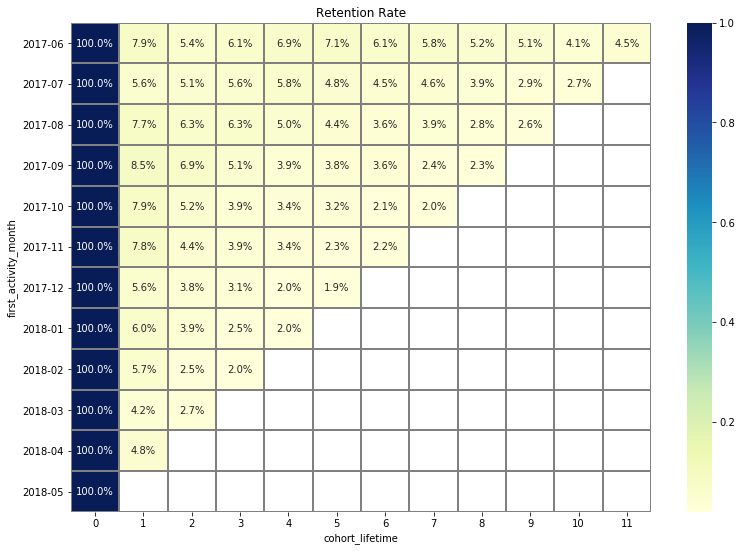

In [28]:
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, cmap='YlGnBu', linecolor='gray');

Во всех когортах коэффициент удержания падает уже со второго месяца,но когорта 06-2017 показывает лучший результат из всех.

### Продажи

In [29]:
orders.columns = ['buy_ts','revenue','uid'] # приведём название столбцов к правильному виду
orders.head()

buy_ts  revenue                   uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

In [30]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])#Изменим тип данных на datetime64

**Когда люди начинают покупать?**

In [31]:
first_visits = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visits.columns = ['uid', 'first_visits_date']
first_order_date = orders.groupby(['uid'])['buy_ts'].min().reset_index()
first_order_date.columns = ['uid', 'first_order']

In [32]:
begin_buy = first_visits.merge(first_order_date, on='uid')
begin_buy['difference'] = begin_buy['first_order'] - begin_buy['first_visits_date']
begin_buy['difference'] = begin_buy['difference']/np.timedelta64(1, 'm')
begin_buy['difference'].mode()


0    1.0
dtype: float64

Большинство людей начинают покупать с 1 минуты.Что опять же подтверждает целенаправленность их действий.

**Сколько раз покупают за период?** 

In [33]:
first_order_date_by_uid = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_uid.name = 'first_order_date'
orders = orders.join(first_order_date_by_uid,on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [34]:
orders.head()

buy_ts  revenue                   uid    first_order_date  \
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00   
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:25:00   
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 00:27:00   
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 00:29:00   
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 07:58:00   

  first_order_month order_month  
0        2017-06-01  2017-06-01  
1        2017-06-01  2017-06-01  
2        2017-06-01  2017-06-01  
3        2017-06-01  2017-06-01  
4        2017-06-01  2017-06-01

In [35]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'count','uid':'nunique'})
orders_grouped_by_cohorts.head()

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01      2354  2023
                  2017-07-01       177    61
                  2017-08-01       174    50
                  2017-09-01       226    54
                  2017-10-01       292    88

In [36]:
orders_grouped_by_cohorts['revenue_per_uid'] = orders_grouped_by_cohorts['revenue']/orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts.head()

revenue   uid  revenue_per_uid
first_order_month order_month                                
2017-06-01        2017-06-01      2354  2023         1.163618
                  2017-07-01       177    61         2.901639
                  2017-08-01       174    50         3.480000
                  2017-09-01       226    54         4.185185
                  2017-10-01       292    88         3.318182

In [37]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime']/ np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

In [38]:
lifetime_pivot = orders_grouped_by_cohorts.pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'revenue_per_uid', aggfunc = 'sum')
lifetime_pivot.fillna('')

cohort_lifetime          0        1        2        3        4        5   \
first_order_month                                                          
2017-06            1.163618  2.90164     3.48  4.18519  3.31818  3.25373   
2017-07            1.136765  1.92308  2.10526    1.625  1.46939  2.15789   
2017-08            1.118978  1.86207  1.88679  1.84091    2.125   1.9375   
2017-09            1.136381  1.68462     1.61  2.21622  1.28846  1.70312   
2017-10            1.143779  1.52427  1.31707  1.32609   1.3871  1.43056   
2017-11            1.179368  1.78829  1.51667  1.99057  1.67901  1.22917   
2017-12            1.152635  1.84932  1.96117  1.84536     1.72  1.66667   
2018-01            1.121554  1.96491  1.91566  1.48837  1.73333            
2018-02            1.121611  1.88136  1.43103  1.79487                     
2018-03            1.168978  1.97778  3.03448                              
2018-04            1.096221  2.82609                                       
2018-05            1.087349                                                
2018-06            1.000000                                                

cohort_lifetime         6        7        8        9        10       11  
first_order_month                                                        
2017-06            4.45161  3.70213  3.65517      3.4  2.13333  1.62264  
2017-07            1.69444  1.28205  1.38095  1.09091  2.03846           
2017-08            1.63333  1.77273  2.42105  1.48387                    
2017-09            1.63636  1.51351   1.4186                             
2017-10            1.53571  1.86567                                      
2017-11            1.64516                                               
2017-12                                                                  
2018-01                                                                  
2018-02                                                                  
2018-03                                                                  
2018-04                                                                  
2018-05                                                                  
2018-06

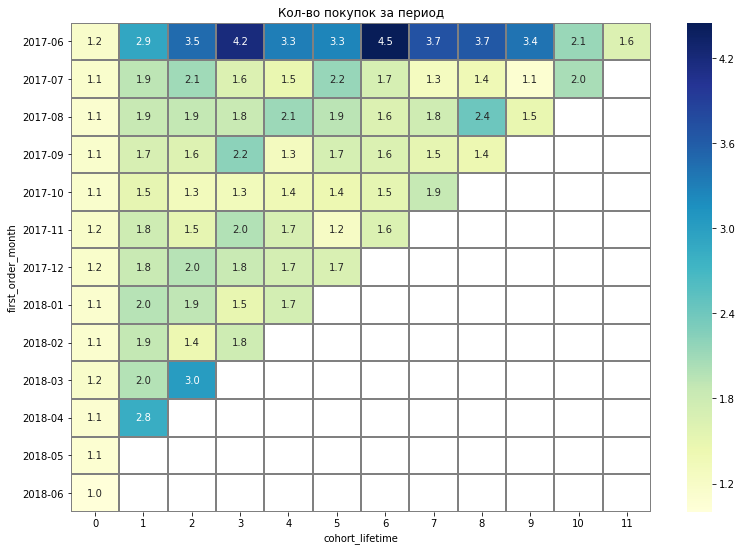

In [39]:
plt.figure(figsize=(13, 9))
plt.title('Кол-во покупок за период')
sns.heatmap(lifetime_pivot, annot=True, fmt='.1f', linewidths=1, cmap='YlGnBu', linecolor='gray');

В первый месяц регистрации пользователи совершают по одной покупке.Со второго и в последующих месяцах совершают по 1-2 покупки. Когорта 2017-06, как и с Retention Rate выделяется на фоне остальных - в среднем эта когорта делает более 3 заказов в месяц.
2018-04 когорта на второй месяц использования ресурса выделилась - практически 3 покупки на клиента, в сравнении с остальными когортами, где, в большинстве, не дотягивает даже до значения в 2 покупки, это выглядит довольно странно, как и показатель "3" у мартовской когорты. Необходимо изучать.


**Какой средний чек?**

In [40]:
orders_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_by_cohorts.head()

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61
                  2017-08-01    885.34    50
                  2017-09-01   1931.30    54
                  2017-10-01   2068.58    88

In [41]:
orders_by_cohorts['revenue_per_user'] = orders_by_cohorts['revenue'] / orders_by_cohorts['uid']
orders_by_cohorts.head()

revenue   uid  revenue_per_user
first_order_month order_month                                 
2017-06-01        2017-06-01   9557.49  2023          4.724414
                  2017-07-01    981.82    61         16.095410
                  2017-08-01    885.34    50         17.706800
                  2017-09-01   1931.30    54         35.764815
                  2017-10-01   2068.58    88         23.506591

In [42]:
orders_by_cohorts = orders_by_cohorts.reset_index()
orders_by_cohorts['first_order_month'] = orders_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
orders_by_cohorts['order_month'] = orders_by_cohorts['order_month'].dt.strftime('%Y-%m')

In [43]:
revenue_per_user_pivot = orders_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean')
revenue_per_user_pivot.fillna('') 

order_month        2017-06  2017-07  2017-08  2017-09  2017-10  2017-11  \
first_order_month                                                         
2017-06            4.72441  16.0954  17.7068  35.7648  23.5066  22.2078   
2017-07                     6.01022  12.3963   21.036  10.7861  6.93816   
2017-08                              5.27652  11.1488  11.8513   12.183   
2017-09                                       5.64453  22.1884  13.4452   
2017-10                                                5.00373  11.2874   
2017-11                                                         5.15468   
2017-12                                                                   
2018-01                                                                   
2018-02                                                                   
2018-03                                                                   
2018-04                                                                   
2018-05                                                                   
2018-06                                                                   

order_month        2017-12  2018-01  2018-02  2018-03  2018-04  2018-05  \
first_order_month                                                         
2017-06            31.0119  25.0332  19.2957  27.2336  25.6813  9.80415   
2017-07            7.89684  6.42111  6.99282  7.38214  12.8618  11.5138   
2017-08            16.9212  12.1391  9.62033  12.6105    21.07  8.30742   
2017-09            138.669  19.8815   26.095  27.4371  16.9614  11.0447   
2017-10            6.75325  7.41315   7.0728  7.25514  6.57321   7.4797   
2017-11            7.33905  6.78658  12.5107  7.45728  4.58083  7.56484   
2017-12            4.73819  7.81658   39.366  48.1351  27.4314  23.5184   
2018-01                     4.13564  8.72123  12.3655  11.1998  4.69956   
2018-02                              4.15699     8.61  4.94241  6.94103   
2018-03                                        4.8388  11.8117  19.2219   
2018-04                                                 4.6576  17.5351   
2018-05                                                         4.66056   
2018-06                                                                   

order_month       2018-06  
first_order_month          
2017-06                    
2017-07                    
2017-08                    
2017-09                    
2017-10                    
2017-11                    
2017-12                    
2018-01                    
2018-02                    
2018-03                    
2018-04                    
2018-05                    
2018-06              3.42

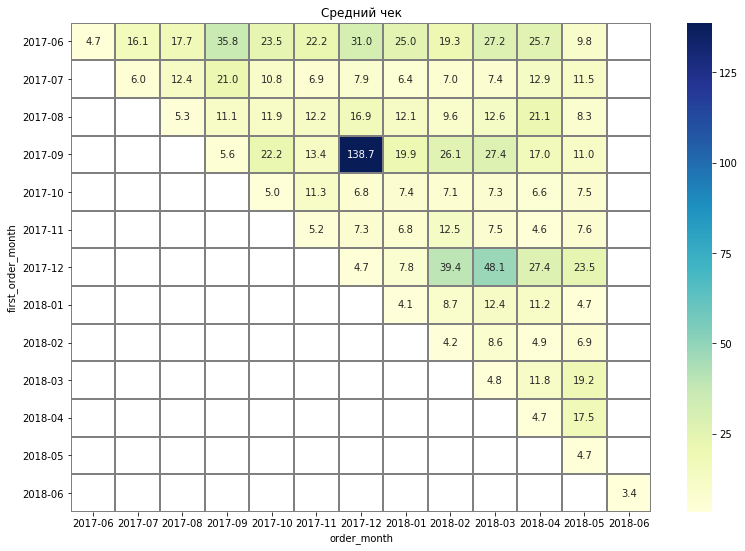

In [44]:
plt.figure(figsize=(13, 9))
plt.title('Средний чек')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, cmap='YlGnBu', linecolor='gray');

Средний чек равен примерно 11 т.р., но есть аномальные когорты, в которых средний чек в несколько раз больше, а цифра в 138т.р. вообще аномально велика. 


**Сколько денег приносят? (LTV)**

In [45]:
#Посчитаем количество новых покупателей (n_buyers) за каждый месяц
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy', 'n_buyers']
cohort_sizes.head()

first_buy  n_buyers
0 2017-06-01      2023
1 2017-07-01      1923
2 2017-08-01      1370
3 2017-09-01      2581
4 2017-10-01      4340

In [46]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку.
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.columns = ['first_buy', 'order_month','revenue']

In [47]:
cohorts.head()

first_buy order_month  revenue
0 2017-06-01  2017-06-01  9557.49
1 2017-06-01  2017-07-01   981.82
2 2017-06-01  2017-08-01   885.34
3 2017-06-01  2017-09-01  1931.30
4 2017-06-01  2017-10-01  2068.58

In [48]:
#Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report = pd.merge(cohort_sizes, cohorts, on='first_buy')
report['first_buy'] = pd.to_datetime(report['first_buy'])
report['order_month'] = pd.to_datetime(report['order_month'])
report.head()


first_buy  n_buyers order_month  revenue
0 2017-06-01      2023  2017-06-01  9557.49
1 2017-06-01      2023  2017-07-01   981.82
2 2017-06-01      2023  2017-08-01   885.34
3 2017-06-01      2023  2017-09-01  1931.30
4 2017-06-01      2023  2017-10-01  2068.58

Для расчёта валовой прибыли допустим, что себестоимость нулевая. Следовательно валовая прибыль = выручка.

In [49]:
report['age'] = (report['order_month'] - report['first_buy']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

first_buy  n_buyers order_month  revenue  age
0 2017-06-01      2023  2017-06-01  9557.49    0
1 2017-06-01      2023  2017-07-01   981.82    1
2 2017-06-01      2023  2017-08-01   885.34    2
3 2017-06-01      2023  2017-09-01  1931.30    3
4 2017-06-01      2023  2017-10-01  2068.58    4

In [50]:
#найдём LTV
report['ltv'] = report['revenue'] / report['n_buyers']
report['first_buy'] = report['first_buy'].dt.strftime('%Y-%m')

In [51]:
#Для наглядности визуализируем когорты в виде сводной таблицы
output = report.pivot_table(
        index='first_buy', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
    
#Найдём итоговый LTV по когортам
itog_LTV = output.cumsum(axis=1)
itog_LTV.fillna('')

age          0     1     2      3      4      5      6      7      8      9   \
first_buy                                                                      
2017-06    4.72  5.21  5.65    6.6   7.62   8.36   9.31   9.89  10.44  11.05   
2017-07    6.01  6.35  6.97   7.33   7.51   7.67   7.79   7.93   8.09   8.24   
2017-08    5.28  5.75  6.21    6.6   7.09   7.37   7.58   7.99   8.28   8.47   
2017-09    5.64  6.76  7.28  11.26  11.66  12.31  13.01  13.25  13.43          
2017-10    5.00  5.54  5.73   5.89   6.04   6.16   6.24   6.36                 
2017-11    5.15  5.55  5.75   6.07   6.22   6.27   6.38                        
2017-12    4.74     5  5.93      7   7.31   7.65                               
2018-01    4.14  4.43  4.73   4.87   4.93                                      
2018-02    4.16  4.44  4.52   4.59                                             
2018-03    4.84  5.14  5.46                                                    
2018-04    4.66  5.19                                                          
2018-05    4.66                                                                
2018-06    3.42                                                                

age           10     11  
first_buy                
2017-06    11.62  11.88  
2017-07      8.4         
2017-08                  
2017-09                  
2017-10                  
2017-11                  
2017-12                  
2018-01                  
2018-02                  
2018-03                  
2018-04                  
2018-05                  
2018-06

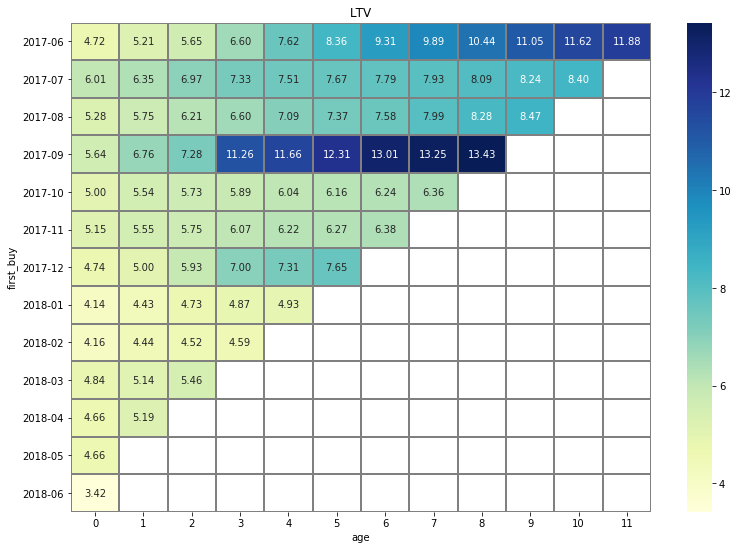

In [52]:
#Cоставим тепловую карту
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(itog_LTV, annot=True, fmt='.2f', linewidths=1, cmap='YlGnBu', linecolor='gray');

В среднем пользователи по когортам приносят около 7 т.р.. Максимальную прибыль показали когорта 2017-06 и 2017-09. Она составила ~12 и ~13,4 соответственно.

### Маркетинг


**Сколько денег потратили? Всего / на каждый источник / по времени**

In [53]:
costs.head()

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

**Всего**

In [54]:
#Найдём сколько всего потратили денег на маркетинг
all_costs_market = costs['costs'].sum()
all_costs_market

329131.62

329131.62 эта сумма ушла для привлечения пользователей.

**На каждый источник**

In [55]:
#Затраты на каждый рекламный источник 
costs_device = costs.groupby('source_id').agg({'costs':'sum'})
costs_device

costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49

На 3 источник рекламы потратили значительно больше, чем на остальные.

**По времени**

In [56]:
report.head()

first_buy  n_buyers order_month  revenue  age       ltv
0   2017-06      2023  2017-06-01  9557.49    0  4.724414
1   2017-06      2023  2017-07-01   981.82    1  0.485329
2   2017-06      2023  2017-08-01   885.34    2  0.437637
3   2017-06      2023  2017-09-01  1931.30    3  0.954671
4   2017-06      2023  2017-10-01  2068.58    4  1.022531

In [57]:
#Посмотрм сколько потратили денег на каждый источник по месяцам
#Приведём дату в нужный нам формат
costs['date_month'] = costs['dt'].astype('datetime64[M]').dt.strftime('%Y-%m')

In [58]:
costs_time = costs.groupby(['source_id','date_month'])['costs'].sum().reset_index()
costs_time


source_id date_month    costs
0           1    2017-06  1125.61
1           1    2017-07  1072.88
2           1    2017-08   951.81
3           1    2017-09  1502.01
4           1    2017-10  2315.75
..        ...        ...      ...
79         10    2018-01   614.35
80         10    2018-02   480.88
81         10    2018-03   526.41
82         10    2018-04   388.25
83         10    2018-05   409.86

[84 rows x 3 columns]

In [59]:
#Для наглядности составим сводную таблицу.
costs_time_month = costs_time.pivot_table(
        index='source_id', 
        columns='date_month', 
        values='costs', 
        aggfunc='sum')
    

In [60]:
costs_time_month

date_month  2017-06  2017-07  2017-08  2017-09   2017-10   2017-11   2017-12  \
source_id                                                                      
1           1125.61  1072.88   951.81  1502.01   2315.75   2445.16   2341.20   
2           2427.38  2333.11  1811.05  2985.66   4845.00   5247.68   4897.80   
3           7731.65  7674.37  6143.54  9963.55  15737.24  17025.34  16219.52   
4           3514.80  3529.73  3217.36  5192.26   6420.84   5388.82   7680.47   
5           2616.12  2998.14  2185.28  3849.14   5767.40   6325.34   5872.52   
9            285.22   302.54   248.93   415.62    609.41    683.18    657.98   
10           314.22   329.82   232.57   460.67    627.24    792.36    645.86   

date_month   2018-01   2018-02   2018-03  2018-04  2018-05  
source_id                                                   
1            2186.18   2204.48   1893.09  1327.49  1467.61  
2            4157.74   4474.34   3943.14  2993.70  2689.44  
3           14808.78  14228.56  13080.85  9296.81  9411.42  
4            5832.79   5711.96   5961.87  4408.49  4214.21  
5            5371.52   5071.31   4529.62  3501.15  3669.56  
9             547.16    551.50    480.29   373.49   362.17  
10            614.35    480.88    526.41   388.25   409.86

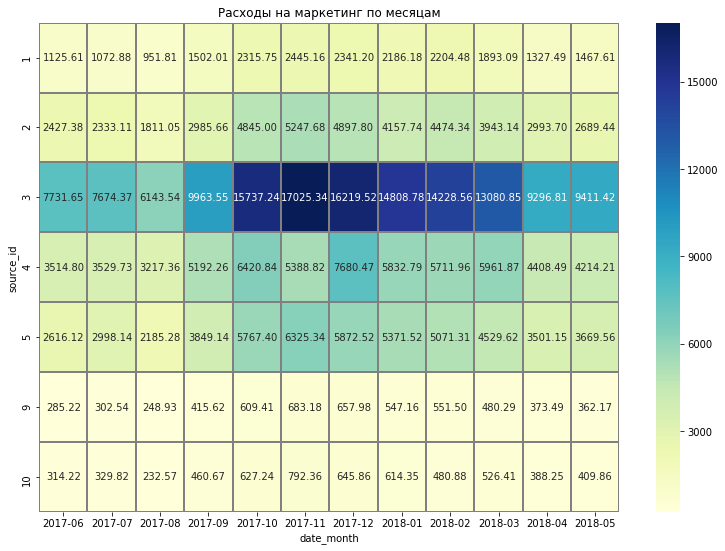

In [61]:
#Для удобства составим тепловую карту
plt.figure(figsize=(13, 9))
plt.title('Расходы на маркетинг по месяцам')
sns.heatmap(costs_time_month, annot=True, fmt='.2f', linewidths=1, cmap='YlGnBu', linecolor='gray');

Больше всего расходов было на 3 источник.

**Сколько стоило привлечение одного покупателя из каждого источника**

In [62]:
#Возьмём датафрейм с количеством покупателей
report.head()

first_buy  n_buyers order_month  revenue  age       ltv
0   2017-06      2023  2017-06-01  9557.49    0  4.724414
1   2017-06      2023  2017-07-01   981.82    1  0.485329
2   2017-06      2023  2017-08-01   885.34    2  0.437637
3   2017-06      2023  2017-09-01  1931.30    3  0.954671
4   2017-06      2023  2017-10-01  2068.58    4  1.022531

In [63]:
#Сгруппируем по дате, количество покупателей
report_new = pd.merge(report, costs_time, left_on='first_buy', right_on='date_month')

In [64]:
report_new.head()

first_buy  n_buyers order_month  revenue  age       ltv  source_id  \
0   2017-06      2023  2017-06-01  9557.49    0  4.724414          1   
1   2017-06      2023  2017-06-01  9557.49    0  4.724414          2   
2   2017-06      2023  2017-06-01  9557.49    0  4.724414          3   
3   2017-06      2023  2017-06-01  9557.49    0  4.724414          4   
4   2017-06      2023  2017-06-01  9557.49    0  4.724414          5   

  date_month    costs  
0    2017-06  1125.61  
1    2017-06  2427.38  
2    2017-06  7731.65  
3    2017-06  3514.80  
4    2017-06  2616.12

In [65]:
#Поделим расходы за каждый месяц на количество людей в когорте
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()


first_buy  n_buyers order_month  revenue  age       ltv  source_id  \
0   2017-06      2023  2017-06-01  9557.49    0  4.724414          1   
1   2017-06      2023  2017-06-01  9557.49    0  4.724414          2   
2   2017-06      2023  2017-06-01  9557.49    0  4.724414          3   
3   2017-06      2023  2017-06-01  9557.49    0  4.724414          4   
4   2017-06      2023  2017-06-01  9557.49    0  4.724414          5   

  date_month    costs       cac  
0    2017-06  1125.61  0.556406  
1    2017-06  2427.38  1.199891  
2    2017-06  7731.65  3.821873  
3    2017-06  3514.80  1.737420  
4    2017-06  2616.12  1.293188

In [66]:
#Составим сводную таблицу для отображения САС
cac = report_new.pivot_table(
        index='source_id', 
        columns='date_month', 
        values='cac', 
        aggfunc='sum')
cac

date_month    2017-06    2017-07    2017-08    2017-09    2017-10    2017-11  \
source_id                                                                      
1            6.676876   6.137119   6.947518   5.237540   4.268664   4.194099   
2           14.398695  13.345923  13.219343  10.411058   8.930876   9.001166   
3           45.862481  43.899152  44.843358  34.743103  29.008737  29.202985   
4           20.849036  20.190863  23.484380  18.105517  11.835650   9.243259   
5           15.518260  17.150047  15.950949  13.422030  10.631152  10.849640   
9            1.691864   1.730598   1.817007   1.449275   1.123336   1.171835   
10           1.863885   1.886646   1.697591   1.606366   1.156203   1.359108   

date_month    2017-12    2018-01    2018-02    2018-03   2018-04   2018-05  
source_id                                                                   
1            3.204928   3.240706   2.415207   1.607492  1.166511  0.491168  
2            6.704723   6.163267   4.902043   3.348265  2.630668  0.900080  
3           22.203313  21.951942  15.588672  11.107430  8.169429  3.149739  
4           10.513990   8.646294   6.257968   5.062443  3.873893  1.410378  
5            8.039042   7.962526   5.556078   3.846267  3.076582  1.228099  
9            0.900726   0.811088   0.604218   0.407832  0.328199  0.121208  
10           0.884134   0.910688   0.526847   0.446994  0.341169  0.137169

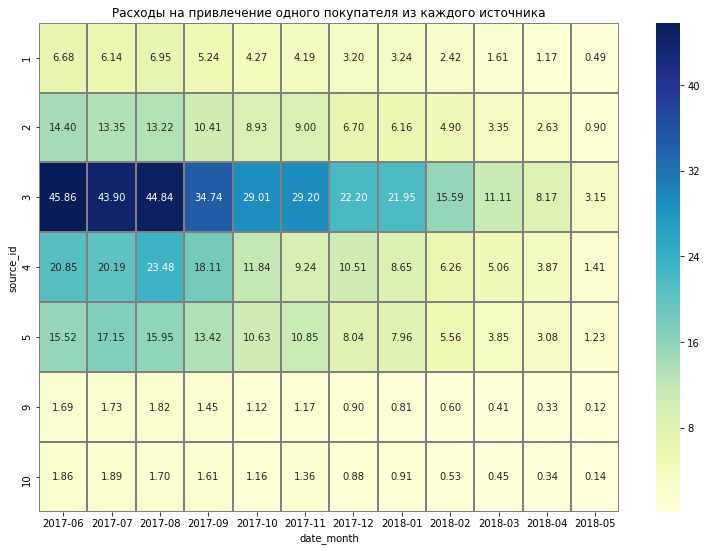

In [67]:
#Для удобства составим тепловую карту
plt.figure(figsize=(13, 9))
plt.title('Расходы на привлечение одного покупателя из каждого источника')
sns.heatmap(cac, annot=True, fmt='.2f', linewidths=1, cmap='YlGnBu', linecolor='gray');

В 3 источнике расходы на привлечение одного покупателя гораздо выше остальных.

**На сколько окупились расходы. (ROI)**

Рассчитаем ROMI: поделим LTV на CAC.

In [68]:
report_new['romi'] = report_new['ltv'] / report_new['cac']


In [69]:
romi = report_new.pivot_table(
        index='source_id', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
romi.fillna('')

age               0         1         2         3         4         5   \
source_id                                                                
1           8.598260  0.783577  0.707128  1.436501  0.595962  0.581421   
2           4.191227  0.378843  0.342396  0.705282  0.287459  0.281097   
3           1.267698  0.115409  0.103322  0.213061  0.087738  0.085693   
4           2.888433  0.257512  0.226733  0.442017  0.190463  0.180829   
5           3.451257  0.314214  0.283204  0.571747  0.245612  0.236874   
9          32.436190  2.923429  2.625982  5.269270  2.252167  2.174033   
10         30.792914  2.774367  2.508713  4.906277  2.130923  2.049298   

age              6         7         8         9         10        11  
source_id                                                              
1          0.630541  0.503327  0.505009  0.541020  0.652861  0.461634  
2          0.303735  0.244320  0.243515  0.256116  0.302201  0.214066  
3          0.093078  0.074572  0.074495  0.079098  0.094240  0.067207  
4          0.199226  0.156676  0.155536  0.169627  0.206805  0.147838  
5          0.258760  0.208908  0.209445  0.226891  0.270797  0.198622  
9          2.385376  1.917562  1.924879  2.088849  2.520654  1.821822  
10         2.195101  1.823659  1.813500  1.955137  2.292758  1.653682

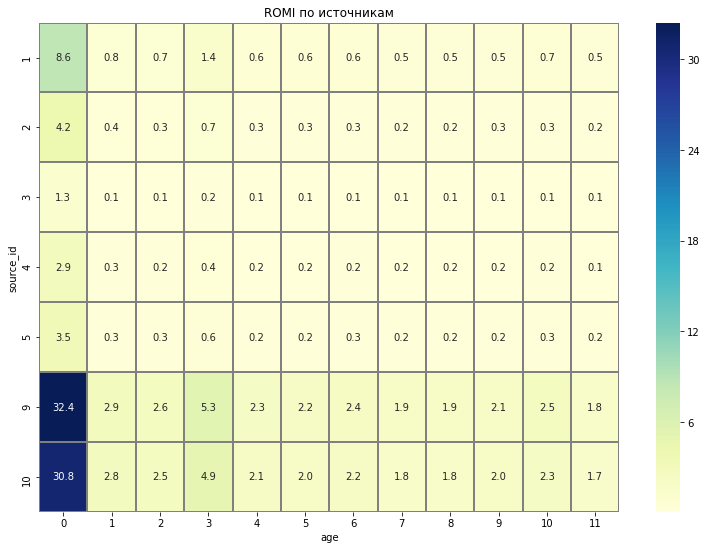

In [70]:
#Для удобства составим тепловую карту
plt.figure(figsize=(13, 9))
plt.title('ROMI по источникам')
sns.heatmap(romi, annot=True, fmt='.1f', linewidths=1, cmap='YlGnBu', linecolor='gray');

9 и 10 источники окупались в каждом месяце, из всех остальных ближе всех к окупаемости был первый источник. 3 источник, с максимальными затратами на рекламу, окупился в ноль, только в 1 месяце.

In [71]:
romi_1 = report_new.pivot_table(
        index='first_buy', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
romi_1.fillna('')

age               0         1         2         3         4         5   \
first_buy                                                                
2017-06    11.994675   1.23219    1.1111   2.42379   2.59607   1.86734   
2017-07    13.943710  0.777689   1.44659  0.832823  0.410156  0.362031   
2017-08    11.205682   1.00237  0.973672  0.830951   1.04921  0.602151   
2017-09    12.758416    2.5261   1.17747   8.98654  0.905387   1.46258   
2017-10    13.234833   1.41709  0.506236  0.415648  0.400875  0.318356   
2017-11    11.202490  0.867639  0.433689  0.706207  0.321671  0.117093   
2017-12    12.049802  0.662164   2.35264   2.70913  0.795818  0.859695   
2018-01     9.123828  0.650281  0.671289  0.314989  0.138321             
2018-02    10.867749  0.727502  0.205266  0.193837                       
2018-03    12.769175  0.794026  0.832732                                 
2018-04    10.540816   1.20309                                           
2018-05    13.667646                                                     

age              6         7         8         9         10        11  
first_buy                                                              
2017-06     2.41304   1.47659   1.40454   1.53802   1.45036  0.652124  
2017-07    0.278883  0.329023  0.374059  0.341377  0.361162            
2017-08    0.447385  0.860109  0.620567  0.399207                      
2017-09     1.58586  0.549596  0.415912                                
2017-10    0.224337  0.305417                                          
2017-11    0.249768                                                    
2017-12                                                                
2018-01                                                                
2018-02                                                                
2018-03                                                                
2018-04                                                                
2018-05

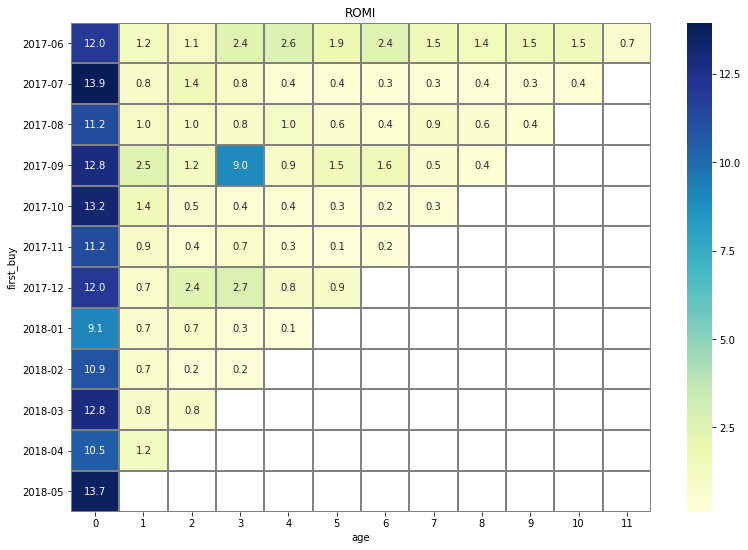

In [72]:
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(romi_1, annot=True, fmt='.1f', linewidths=1, cmap='YlGnBu', linecolor='gray');

Когорта 2017-06 окупалась на всём времени жизни. Также неплохо показала себя когорта 2017-09 и декабрьская на 2 и 3 месяц жизни.

In [73]:
romi_1.cumsum(axis=1).mean(axis=0)

age
0     11.946568
1     12.868300
2     13.951808
3     15.837340
4     17.144902
5     18.835679
6     19.603298
7     21.448392
8     23.308561
9     21.714999
10    24.482607
11    30.159834
dtype: float64

**Количество пользователей по устройствам**

In [74]:
visits_by_device = visits.groupby('device').agg({'uid': 'count'})
visits_by_device.head()

uid
device         
desktop  262567
touch     96833

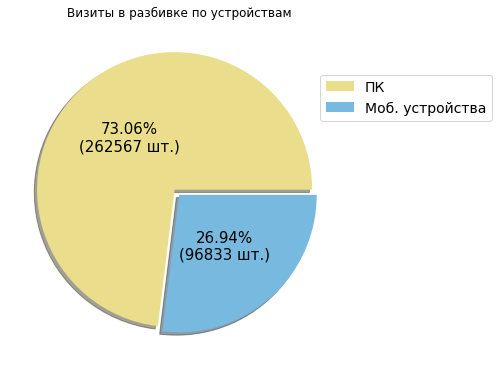

In [75]:
summary = visits_by_device.values.sum()

def func_pct(pct):
    value = float(pct/100.*summary)
    return "{:.2f}%\n({:.0f} шт.)".format(pct, value)

explode = (0.05, 0)

ax_pie = visits_by_device.plot(kind='pie', y='uid', fontsize=15, use_index=False, shadow=True, explode=explode,
                        title = 'Визиты в разбивке по устройствам', pctdistance=0.5, figsize=(15,5), 
                        autopct=lambda pct: func_pct(pct), colors=['#EADD8B', '#78B9DF'], labels=None)

plt.tight_layout(pad=0)

legend = ax_pie.legend(['ПК', 'Моб. устройства'], bbox_to_anchor=(0.89,0.87), prop={'size':14})
y_label = ax_pie.set_ylabel('')

Из графика мы видим, что количество пользователей с ПК почти в 3 раза больше! Количество пользователей с телефона достаточно низкое, стоит проверить мобильную версию приложения.

**Количество пользователей по рекламным источникам**

In [76]:
visits_sorce = visits.groupby(['device','source_id']).agg({'uid': 'count'}).reset_index()


In [77]:
device_dis = pd.merge(visits_sorce,report_new, on = 'source_id' )
device_dis_desktop = device_dis[device_dis['device'] == 'desktop']
device_dis_touch = device_dis[device_dis['device'] == 'touch']


In [78]:
trace_desktop = go.Bar(
    x = device_dis_desktop['source_id'],
    y = device_dis_desktop['uid'],
    name = 'ПК'
)
trace_touch = go.Bar(
    x = device_dis_touch['source_id'],
    y = device_dis_touch['uid'],
    name = 'Моб. устройство'
)
layout = go.Layout(
    title='Количество пользователей по рекламным источникам',
    yaxis_title = 'Пользователи',
    xaxis_title = 'Рекламные источники'
) 
fig = go.Figure(data = [trace_desktop, trace_touch], layout = layout)
fig.show()

И с ПК и с мобильного устройства из 4 источноника пользователей пришло больше, хотя денег на рекламу он получил в 2.3 раза меньше чем 3 источник.

In [79]:
source_visit_d = visits.pivot_table(index = 'session_date', columns = 'source_id', values ='uid', aggfunc = 'count')
source_visit_w = visits.pivot_table(index = 'session_week', columns = 'source_id', values ='uid', aggfunc = 'count')
source_visit_m = visits.pivot_table(index = 'session_month', columns = 'source_id', values ='uid', aggfunc = 'count')


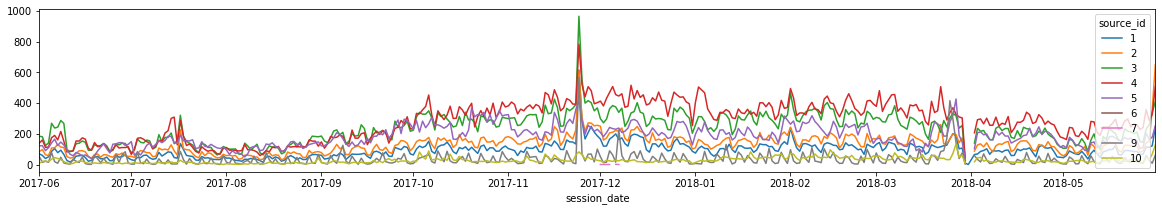

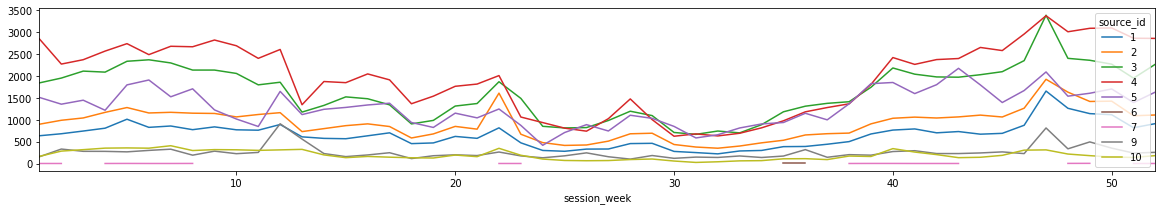

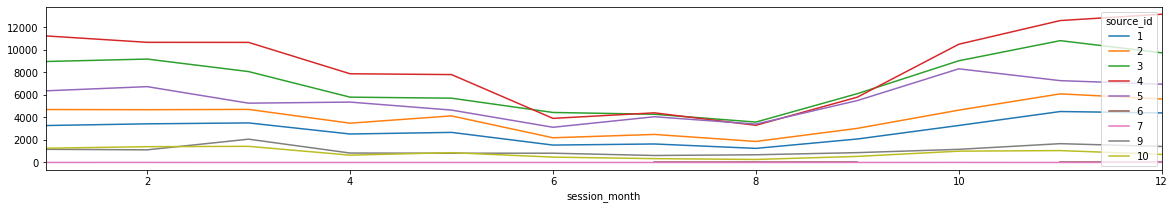

In [80]:
source_visit_d.plot(figsize=(20, 3));
source_visit_w.plot(figsize=(20, 3));
source_visit_m.plot(figsize=(20, 3));

Из графиков мы видим, что лидеры по посещаемости 3 и 4 источники. Так же посещаемость падает в летние месяцы и возростает в зимние.

## Шаг 3.Общий вывод.

Мы имеем 907 пользователей и 987 сессий, в среднем в день.
+ Большинство сессий имеют длительность 1-2 минуты, т.е. люди заходят на ресурс и, сделав пару щелчков, выходят оттуда. 
+ Большая часть клиентов после первой покупки уже не возвращаются о чём свидетельствует низкий, во всех когортах, коэффициент удержания, но Когорта 2017-06 выделяется на фоне остальных - в среднем эта когорта делает более 3 заказов в месяц. 2018-04 когорта на второй месяц использования ресурса выделилась - практически 3 покупки на клиента, в сравнении с остальными когортами, где, в большинстве, не дотягивает даже до значения в 2 покупки, это выглядит довольно странно, как и показатель "3" у мартовской когорты. Необходимо изучать. 
+ В 73% визитов, пользователи пользуются ПК.Оставшие 27% непозволительно низки для современного мира гаджетов, стоит проверить мобильную версию приложения.
+ Средний чек(траты пользователя за месяц) равен примерно 11 т.р., но есть аномальная  сентябрьская когорта, в которой в декабре 2017 средний чек составил 138 т.р. Этот случай стоит изучить детально.
+ В среднем пользователи по когортам приносят около 7 т.р.(LTV). Максимальную прибыль показали когорта 2017-06 и 2017-09. Она составила ~12 и ~13,4 соответственно.
+ 329131.62 эта сумма ушла для привлечения пользователей.
+ На 3 источник рекламы потратили значительно больше, чем на остальные. 
+ У пользователей явно прослеживается сезонность, в летние месяцы, они меньше посещают ресурс. И наоборот зимой, более охотно.
+ ***Подводя итог: Необходимо пересмотреть рекламную политику компании, необходимо исследовать поведение клиентов, которые остаются и покупают дольше и чаще, чем другие, и необходимо посмотреть в сторону мобильного приложения, которое, дало бы возможность всем пользователям покупать билеты "на ходу" с комфортом.***

